# Filtering vectors with Vertex Matching Engine

> In Vertex AI Matching Engine, you can restrict vector matching searches to a subset of the index by using Boolean rules

> Boolean predicates tell Matching Engine which vectors in the index to ignore. 

See the [filter vector docs](https://cloud.google.com/vertex-ai/docs/matching-engine/filtering)

### this notebook...

**major tasks**

* Use pre-trained TFHub model to convert images to embedding vectors

* Use Python SDK to query deployed ANN & BF indexes - from **(Notebook Link)** 

* TODO

**vector attributes**

* in this example, vectors are tagged with a `category` and a `tag_1`
* `category` and `tag_1` are *namespaces*
* `Beauty` , `Toys & Games`, and `Sports & Outdoors` are *tokens* from the `category` namespace (see all tokens below)
* `even` and `odd` are *tokens* from the `tag_1` namespace

```

{
    "id":"B00C19IQ40",
    "embedding":[0.15452695, ..., 0.0047538234],
    "restricts":[
        {"namespace" : "category", "allow" : ["All Beauty"]},
        {"namespace" : "tag_1", "allow" : ["even"]}
    ]
}

```

**queries**

* Queries express an `AND` logical operator *across* namespaces
* Queries express an `OR` logical operator *within* namespaces
* A query that specifies `{color: red, blue}, {shape: square, circle}`, matches all database points that satisfy `(red || blue) && (square || circle)`
* A query that specifies `{color: red}`, matches all `red` objects of any kind, with no restriction on `shape`


In [1]:
PROJECT_ID = 'hybrid-vertex'  # <--- TODO: CHANGE THIS
LOCATION = 'us-central1' 
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


## pip & package

In [130]:
import os
import time

import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from IPython.display import clear_output, Image
from IPython.core.display import HTML


In [33]:
from google.cloud import aiplatform as vertex_ai
from google.cloud import storage

from pprint import pprint

storage_client = storage.Client(project=PROJECT_ID)

vertex_ai.init(project=PROJECT_ID,location=LOCATION)

# Prepare test queries

* original image size - `100x100`
* `42,000` train product images, with title, description, and each assigned a single product category
* `6,368` test product images, with title, description, but no `category`

```
Product Category          value_counts
Arts, Crafts & Sewing        2225
Beauty                       2202
Grocery & Gourmet Food       2201
Sports & Outdoors            2201
Automotive                   2200
Industrial & Scientific      2200
Musical Instruments          2200
Appliances                   2200
Office Products              2200
All Beauty                   2200
Toys & Games                 2200
Electronics                  2200
All Electronics              2200
Cell Phones & Accessories    2200
Patio, Lawn & Garden         2200
Baby                         2200
Baby Products                2200
Health & Personal Care       2200
Tools & Home Improvement     2200
Clothing, Shoes & Jewelry    2200
Pet Supplies                 2200
```

## read and decode query images

In [68]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims=[IMG_HEIGHT, IMG_WIDTH]):
    # Read the file
    img = tf.io.read_file(filename)
  
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    # This makes the img 1 x 224 x 224 x 3 tensor with the data type of float32
    img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)


def create_test_queries(embedder, img_uris):

    dataset_embeddings = []
    ids_list = []
    
    start = time.time()
        
    for uri in img_uris:
        img_tensor = read_and_decode(uri, [IMG_WIDTH, IMG_HEIGHT])
        embeddings = embedder(img_tensor)
        dataset_embeddings.extend(embeddings)
        
        x = uri.split("/")[-1]
        x = x.split(".")[0]
        ids_list.append(x)
        
    dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
    
    end = time.time()
    elapsed_time = round((end - start), 2)
    print(f'Elapsed time writting embeddings: {elapsed_time} seconds\n')
  
    # return dataset_embeddings, ids_list, id_cat_list
    return dataset_embeddings, ids_list


connect to Cloud Storage...

In [11]:
BUCKET = 'retail-products-kaggle'
IMAGE_DIR = f'gs://{BUCKET}'
!gsutil ls $IMAGE_DIR

gs://retail-products-kaggle/retail-products-classification.zip
gs://retail-products-kaggle/data-full/
gs://retail-products-kaggle/dataset/
gs://retail-products-kaggle/indexes/
gs://retail-products-kaggle/pipeline_root/
gs://retail-products-kaggle/pipelines_root/
gs://retail-products-kaggle/saved-models/


In [19]:
# train and test images 
DATA_FOLDER = 'data-full' 
TRAIN_CSV_URI = f'gs://{BUCKET}/{DATA_FOLDER}/train.csv'
TEST_CSV_URI = f'gs://{BUCKET}/{DATA_FOLDER}/test.csv'

train_csv = pd.read_csv(TRAIN_CSV_URI)
test_csv = pd.read_csv(TEST_CSV_URI)

TEST_IMG_DIR = f'gs://{BUCKET}/{DATA_FOLDER}/test/test'
TEST_LIST_DIR = tf.io.gfile.listdir(TEST_IMG_DIR)

print(f"Shape of train_csv: {train_csv.shape}")
print(f"Shape of test_csv: {test_csv.shape}")
print(f"Number of test image files: {len(TEST_LIST_DIR)}")

Shape of train_csv: (46229, 4)
Shape of test_csv: (10596, 3)
Number of test image files: 6367


### Inspect `train` and `test` images

In [23]:
# importing Image class from PIL package
from PIL import Image

file_uri_list = []

for file in TEST_LIST_DIR[:10]:
    file_uri = f"{TEST_IMG_DIR}/{file}"
    file_uri_list.append(file_uri)

# file_uri_list

['gs://retail-products-kaggle/data-full/test/test/098415096X.jpg',
 'gs://retail-products-kaggle/data-full/test/test/1134872615.jpg',
 'gs://retail-products-kaggle/data-full/test/test/1403710066.jpg',
 'gs://retail-products-kaggle/data-full/test/test/1403737010.jpg',
 'gs://retail-products-kaggle/data-full/test/test/1403742618.jpg',
 'gs://retail-products-kaggle/data-full/test/test/1403765049.jpg',
 'gs://retail-products-kaggle/data-full/test/test/1403766355.jpg',
 'gs://retail-products-kaggle/data-full/test/test/1403778809.jpg',
 'gs://retail-products-kaggle/data-full/test/test/1403794677.jpg',
 'gs://retail-products-kaggle/data-full/test/test/1427616566.jpg']

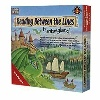

In [51]:
# FILE_NAME = f'{DATA_FOLDER}/test/test/098415096X.jpg' # rule book for game -  allow: 'Toys & Games'  | restrict: 'Arts, Crafts & Sewing'
# FILE_NAME = f'{DATA_FOLDER}/test/test/1134872615.jpg' # educational computer game, scenic cover photo - allow: 'Toys & Games' | restrict: 'Patio, Lawn & Garden'
# FILE_NAME = f'{DATA_FOLDER}/test/test/1403710066.jpg' # Tom Sawyer - allow: 'Sports & Outdoors' | restrict: 'Toys & Games'
# FILE_NAME = f'{DATA_FOLDER}/test/test/1403737010.jpg' # "Little Women" book - allow: 'Toys & Games' | restrict: 'Baby', 'Baby Products'
# FILE_NAME = f'{DATA_FOLDER}/test/test/1403742618.jpg' # kids book(?) - allow: 'Toys & Games' | restrict: 'Pet Supplies' 'Clothing, Shoes & Jewelry'
# FILE_NAME = f'{DATA_FOLDER}/test/test/1403765049.jpg' # NO IMAGE AVAILABLE
# FILE_NAME = f'{DATA_FOLDER}/test/test/1403766355.jpg' # My 2nd Grade (computer game?) - allow: 'Toys & Games', 'Electronics', 'All Electronics' | restrict: 'Baby Products'
# FILE_NAME = f'{DATA_FOLDER}/test/test/1403778809.jpg' # charlie brown image - allow: 'Toys & Games' | restrict: 'Baby', 'Baby Products'
# FILE_NAME = f'{DATA_FOLDER}/test/test/1403794677.jpg' # Astronaut - allow: 'Arts, Crafts & Sewing', 'Industrial & Scientific' | restrict: 'Pet Supplies', 'Baby Products'
# FILE_NAME = f'{DATA_FOLDER}/test/test/1427616566.jpg' # Habitat - allow: 'Toys & Games', 'Electronics', 'All Electronics' | restrict: 'Pet Supplies', 'Patio, Lawn & Garden'

bucket = storage_client.get_bucket(BUCKET)
blob = bucket.get_blob(FILE_NAME)
Image(blob.download_as_bytes(), width=300, height=300)

In [76]:
# search title, description, category
# category = train_csv.loc[train_csv['ImgId'] == IMAGE_ID, 'categories'].item()

IMAGE_ID = '1403737010'

sample = test_csv.loc[test_csv['ImgId'] == IMAGE_ID]

print(f"Title: {sample['title'].item()}\n")
print(f"Description: \n{sample['description'].item()}\n")

sample

Title: Little Women

Description: 
Introduce your child to Louisa May Alcott's Little Women in this delightful 182-page condensation of the classic novel. This timeless story has been adapted by Bethany Snyder and retains the phrasing and flavor of the original. Illustrated with black and white drawings by artist Martin Hargreaves, the hardcover book will be a wonderful addition to your child's bookshelf. This beautiful book is part of The Great Classics for Children series published by Dalmatian Press and brought to you by Bendon Publishing. Bendon Publishing International provides entertaining, high quality books and activities for children.



,ImgId,title,description
9324,1403737010,Little Women,Introduce your child to Louisa May Alcott's Li...


### download pre-trained encoder from TF Hub

In [14]:
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
TF_HUB_MODEL_DIR = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

In [8]:
layers = [
      hub.KerasLayer(
          f"{TF_HUB_MODEL_DIR}",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Flatten()
]
model = tf.keras.Sequential(
    layers, name='visual_embedding'
)
print(model.summary())

2022-11-04 06:30:22.367455: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "visual_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
None


### convert images to vector embeddings using `model.predict()`

In [84]:
# IMG_PATH = f'gs://{BUCKET}/{DEST_FOLDER}/test/test'
# IMG_PATH = f'gs://{BUCKET}/{DEST_FOLDER}/train/train'

# create_test_queries(embedder, img_uris)

test_embeddings, test_ids = create_test_queries(
    lambda x: model.predict(x),
    file_uri_list,
)

# clean output
cleaned_test_embs = [x.numpy() for x in test_embeddings]
cleaned_test_ids = [x for x in test_ids]

print(f"Shape of test_embeddings   : {len(test_embeddings)}")
print(f"Shape of cleaned_test_embs : {len(cleaned_test_embs)}\n")

print(f"Shape of test_ids          : {len(test_ids)}")
print(f"Shape of cleaned_test_ids  : {len(cleaned_test_ids)}")
print(f"cleaned_test_ids           : {cleaned_test_ids[:3]}\n")
cleaned_test_embs[0]

Elapsed time writting embeddings: 1.91 seconds

Shape of test_embeddings   : 10
Shape of cleaned_test_embs : 10

Shape of test_ids          : 10
Shape of cleaned_test_ids  : 10
cleaned_test_ids           : ['098415096X', '1134872615', '1403710066']



array([0.08451159, 0.        , 0.00108564, ..., 0.3638365 , 0.11259918,
       0.        ], dtype=float32)

## Deployed index endpoints

> `index` + `index_endpoint`

In [15]:
# Matching Engine's VPC Network
PROJECT_NUMBER = 934903580331
VPC_NETWORK_NAME = 'ucaip-haystack-vpc-network'
vpc_network_resource_uri = f'projects/{PROJECT_NUMBER}/global/networks/{VPC_NETWORK_NAME}'

> Retrieve an existing index endpoint given a name or ID

```
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(
                index_endpoint_name='projects/123/locations/us-central1/indexEndpoints/my_index_endpoint_id'
)
```

In [89]:
# tree-ah index -> ann_1280_deployed_index_v5 
ann_IndexEndpoint_ResourceName = "projects/934903580331/locations/us-central1/indexEndpoints/8693644926778343424"
my_ann_IndexEndpoint = vertex_ai.MatchingEngineIndexEndpoint(index_endpoint_name=ann_IndexEndpoint_ResourceName)

# brute force index -> brute_force_1280_deployed_index_v5
bf_IndexEndpoint_ResourceName = "projects/934903580331/locations/us-central1/indexEndpoints/4594243365964349440"
my_bf_IndexEndpoint = vertex_ai.MatchingEngineIndexEndpoint(index_endpoint_name=bf_IndexEndpoint_ResourceName)

print(f"my_ann_IndexEndpoint: {my_ann_IndexEndpoint}\n")
print(f"my_bf_IndexEndpoint: {my_bf_IndexEndpoint}")

my_ann_IndexEndpoint: <google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint.MatchingEngineIndexEndpoint object at 0x7f7888094a90> 
resource name: projects/934903580331/locations/us-central1/indexEndpoints/8693644926778343424

my_bf_IndexEndpoint: <google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint.MatchingEngineIndexEndpoint object at 0x7f78880ffe50> 
resource name: projects/934903580331/locations/us-central1/indexEndpoints/4594243365964349440


## Query indexes

**Query deployed indexes**
> * `Match` vs `BatchMatch` ? 
> * single vs ~many query items ?

**queries**

* Queries express an `AND` logical operator *across* namespaces
* Queries express an `OR` logical operator *within* namespaces
* A query that specifies `{color: red, blue}, {shape: square, circle}`, matches all database points that satisfy `(red || blue) && (square || circle)`
* A query that specifies `{color: red}`, matches all `red` objects of any kind, with no restriction on `shape`

**create class for** `namespace`
* specifies the rules for determining the datapoints that are eligible for each matching query,
* overall query is an AND across `namespaces`

In [90]:
from dataclasses import dataclass, field

@dataclass
class Namespace:
    name: str
    allow_tokens: list = field(default_factory=list)
    deny_tokens: list = field(default_factory=list)

### helper function

In [187]:
import time 

def single_query_retrieval( 
    index_endpoint_resource, 
    deployed_index_id, 
    num_neighbs, 
    test_query,
    query_id,
    cat_allows, 
    cat_denies, 
    tag_1_allows,
    tag_1_denies,
):
    '''
    index_endpoint_resource (MatchingEngineIndexEndpoint): 
        Matching Engine index endpoint resource for Vertex AI
    
    deployed_index_id (str): 
        The ID of the DeployedIndex to match the queries against
    
    num_neighbs (int):
        number of nearest neighbors to retrieve with each query
    
    test_query List[List[float]]): 
        A list of queries. Each query a list of floats, 
        representing a single embedding
        e.g., `array([0.2, ..., 0.4], dtype=float32)`
        
    query_id (str):
        id of query product
    
    cat_allows List[str]):
        allow tokens for the "category" namespace
    
    cat_denies List[str]):
        deny tokens for the "category" namespace
    
    tag_1_allows List[str]):
        allow tokens for the "tag_1" namespace
    
    tag_1_denies List[str]):
        deny tokens for the "tag_1" namespace
    
    '''
    print(f'Restricts...\n cat_allows: {cat_allows}, cat_denies: {cat_denies},\ntag_1_allows: {tag_1_allows}, tag_1_denies: {tag_1_denies}\n')
    bucket = storage_client.get_bucket(BUCKET)
    
    # call match on tree-ah index endpoint
    start = time.time()
    
    response = my_ann_IndexEndpoint.match(
        deployed_index_id=deployed_index_id, 
        queries=test_query, 
        num_neighbors=num_neighbs,
        filter=[         
            Namespace(name="category", allow_tokens=cat_allows, deny_tokens=cat_denies), 
            Namespace(name="tag_1", allow_tokens=tag_1_allows, deny_tokens=tag_1_denies)
        ]
    )
    
    end = time.time()
    elapsed_time = round((end - start), 2)
    print(f'Elapsed time querying index-endpoint: {elapsed_time} seconds\n')
    
    # ===============================================================
    # gather metadata for query item...
    # ===============================================================
    
    print("--> query item...\n")
    q_title = test_csv.loc[test_csv['ImgId'] == query_id, 'title'].item()
    q_desc = test_csv.loc[test_csv['ImgId'] == query_id, 'description'].item()
    print(f"id: {query_id} | title: {q_title} | description:\n{q_desc}\n")
    
    query_id_filename = f'data-full/test/test/{query_id}.jpg'
    blob = bucket.blob(query_id_filename)
    z = Image(blob.download_as_bytes(), width=200, height=200)
    display(z)
    
    # ===============================================================
    # gather metadata for NNs...
    # ===============================================================
    
    print(f"\n--> {num_neighbs} nearest neighbors...\n")
    nn_ids_list = []
    nn_distance_list = []
    # NN ids n distances
    for neighbor in response[0]:
        nn_ids_list.append(neighbor.id)
        nn_distance_list.append(round(neighbor.distance,2))

    # for img_id in nn_ids_list:
    for img_id, nn_dist in zip(nn_ids_list, nn_distance_list):
        nn_cat = train_csv.loc[train_csv['ImgId'] == img_id, 'categories'].item()
        nn_title = train_csv.loc[train_csv['ImgId'] == img_id, 'title'].item()
        nn_desc = train_csv.loc[train_csv['ImgId'] == img_id, 'description'].item()
        
        print(f"title: '{nn_title}'\nid: {img_id} | dist: {nn_dist} | category: '{nn_cat}' | description:\n'{nn_desc}'")
        # print(f"id: {img_id} | title: '{nn_title}' | dist: {nn_dist} | category: '{nn_cat}' | description:\n'{nn_desc}'")
        
        filename = f'data-full/train/train/{img_id}.jpg'
        blob = bucket.blob(filename)
        y = Image(blob.download_as_bytes(), width=200, height=200)
        display(y)
        print('\n')
        
        
    return response

### no restricts specified

Restricts...
 cat_allows: [], cat_denies: [],
tag_1_allows: [], tag_1_denies: []

Elapsed time querying index-endpoint: 0.03 seconds

--> query item...

id: 098415096X | title: Malifaux: 2nd Edition Rulebook | description:
The next level of hurt is here. They've bringing back Malifaux with bigger guns, sharper teeth, and more chest-pounding action than you can believe. They've added new characters to the game and a new way to build each character using their brand new upgrade system. It doesn't stop there, new stories will keep you on your toes, while reliving past events from your favorite characters!



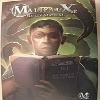


--> 5 nearest neighbors...

title: 'Warhammer Fantasy Roleplay: The Gathering Storm'
id: 1589946987 | dist: 682.58 | category: 'Toys & Games' | description:
'FFGWHF04 The Gathering Storm Warhammer Fantasy Roleplay Game by Fantasy Flight GamesDeath. Misery. Peril. Suffering. Disaster. And that is just the weather! The Gathering Storm is a complete campaign for Warhammer Fantasy Roleplay that centers around a series of bizarre events that bring the heroes face-to-face with dangerous enemies, moral dilemmas, and the raw fury of nature. In addition to introducing many sessions of exciting adventure, this campaign guide provides detailed information on the town of Stromdorf and a number of its odd citizens, as well as colorful maps that bring Stromdorf and the surrounding region to life.'


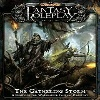



title: 'Once Upon a Time: Dark Tales'
id: 1589780604 | dist: 661.28 | category: 'Toys & Games' | description:
'Explore the grim side of your stories with the addition of the Dark Tales expansion to your Once Upon a Time storytelling card game. The 56 cards included in the set are designed to be mixed in with the original Once Upon a Time game, to provide new story elements and endings. In these stories, trolls lurk under every footbridge, inconsolable wraiths search for their lost loves, fiends tempt the innocent, and evil stepmothers serve up children in tasty stews.Not every fairy tale has a happy ending...'


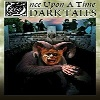



title: 'A Woman's View... Through Child Eyes'
id: B000CA2JQ6 | dist: 658.17 | category: 'Baby Products' | description:
'JACKIE RICHARDSON has been involved in Canada s blues, jazz and theatre scenes for more than 35 years.  A Woman s View...  features her diverse talent-extraordinary vocal prowess singing jazz, blues and gospel, along with sensitive readings of poems by Colina Philips and Salome Bey.'


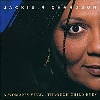



title: 'Chipper Jones Atlanta Braves All-Star 12x18 Lithograph'
id: B0000AX6EE | dist: 655.84 | category: 'Sports & Outdoors' | description:
'Get the Big Picture! A great collector's item for MLB fans. Large 12 x 18 lithograph.'


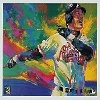



title: 'Baby Carrier - Black'
id: B000813EQ8 | dist: 650.51 | category: 'Baby' | description:
'Body Glove baby carrier is an innovative baby carrier made for water and land. The Body Glove baby carrier securely snuggles baby to your body safely during water play. The Body Glove baby carrier is made of neoprene which helps regulate baby's body temperature for comfort. The Body Glove baby carrier has Padded Shoulder Straps that provide comfort and quick release buckle for safety. This baby carrier can be used as a front carrier or side sling with choice of two positions: criss - cross strapping or around the neck. The Body Glove baby carrier has Adjustable leg straps for a better fit. Rolls up for quick and easy storage and travel.4 Months to 2 Years - up to 25 lbs.Features:Hands FreeWater FriendlyCan be used as a front carrier or side sling'


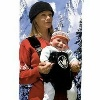

[[MatchNeighbor(id='1589946987', distance=682.5783081054688),
  MatchNeighbor(id='1589780604', distance=661.2794189453125),
  MatchNeighbor(id='B000CA2JQ6', distance=658.1710205078125),
  MatchNeighbor(id='B0000AX6EE', distance=655.8359375),
  MatchNeighbor(id='B000813EQ8', distance=650.5066528320312)]]

In [188]:
# not specifying allow/deny tokens
CAT_ALLOWS = [] # ['Toys & Games']
CAT_DENIES = [] # ['Arts, Crafts & Sewing']

TAG_ALLOWS = [] # ["even","odd"]
TAG_DENIES = [] # ["even","odd"]

QUERY_IMG_ID = cleaned_test_ids[:1][0]
QUERY_IMG_EMB = cleaned_test_embs[:1]


response = single_query_retrieval(
    index_endpoint_resource=my_ann_IndexEndpoint, 
    deployed_index_id='ann_1280_deployed_index_v5', 
    num_neighbs=5, 
    test_query=QUERY_IMG_EMB,
    query_id=QUERY_IMG_ID,
    cat_allows=CAT_ALLOWS, 
    cat_denies=CAT_DENIES, 
    tag_1_allows=TAG_ALLOWS,
    tag_1_denies=TAG_DENIES,
)

response

### restrict a nearest neighbor's category

Restricts...
 cat_allows: [], cat_denies: ['Baby'],
tag_1_allows: [], tag_1_denies: []

Elapsed time querying index-endpoint: 0.04 seconds

--> query item...

id: 098415096X | title: Malifaux: 2nd Edition Rulebook | description:
The next level of hurt is here. They've bringing back Malifaux with bigger guns, sharper teeth, and more chest-pounding action than you can believe. They've added new characters to the game and a new way to build each character using their brand new upgrade system. It doesn't stop there, new stories will keep you on your toes, while reliving past events from your favorite characters!



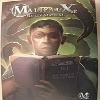


--> 5 nearest neighbors...

title: 'Warhammer Fantasy Roleplay: The Gathering Storm'
id: 1589946987 | dist: 682.58 | category: 'Toys & Games' | description:
'FFGWHF04 The Gathering Storm Warhammer Fantasy Roleplay Game by Fantasy Flight GamesDeath. Misery. Peril. Suffering. Disaster. And that is just the weather! The Gathering Storm is a complete campaign for Warhammer Fantasy Roleplay that centers around a series of bizarre events that bring the heroes face-to-face with dangerous enemies, moral dilemmas, and the raw fury of nature. In addition to introducing many sessions of exciting adventure, this campaign guide provides detailed information on the town of Stromdorf and a number of its odd citizens, as well as colorful maps that bring Stromdorf and the surrounding region to life.'


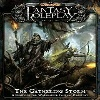



title: 'Once Upon a Time: Dark Tales'
id: 1589780604 | dist: 661.28 | category: 'Toys & Games' | description:
'Explore the grim side of your stories with the addition of the Dark Tales expansion to your Once Upon a Time storytelling card game. The 56 cards included in the set are designed to be mixed in with the original Once Upon a Time game, to provide new story elements and endings. In these stories, trolls lurk under every footbridge, inconsolable wraiths search for their lost loves, fiends tempt the innocent, and evil stepmothers serve up children in tasty stews.Not every fairy tale has a happy ending...'


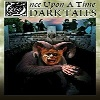



title: 'A Woman's View... Through Child Eyes'
id: B000CA2JQ6 | dist: 658.17 | category: 'Baby Products' | description:
'JACKIE RICHARDSON has been involved in Canada s blues, jazz and theatre scenes for more than 35 years.  A Woman s View...  features her diverse talent-extraordinary vocal prowess singing jazz, blues and gospel, along with sensitive readings of poems by Colina Philips and Salome Bey.'


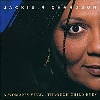



title: 'Chipper Jones Atlanta Braves All-Star 12x18 Lithograph'
id: B0000AX6EE | dist: 655.84 | category: 'Sports & Outdoors' | description:
'Get the Big Picture! A great collector's item for MLB fans. Large 12 x 18 lithograph.'


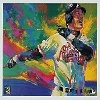



title: 'Living Stone'
id: 1932697810 | dist: 640.95 | category: 'Toys & Games' | description:
'Africa, 1855, The Scottish missionary, Dr. David Livingstone, has been researching African tribes and the flora and fauna of the area. As part of the Livingstone expedition, strategically set up tents in various regions, while collecting gemstones found along the Zambezi River bank. Gain the most victory points and the favor of Queen Victoria to win. 2 to 5 players. 35 minutes. In this game you follow in the footsteps of David Livingstone to the roaring Victoria Falls. On your way you may want to try your luck in the Diamond mining or you may prefer to seek a more calculable risk.'


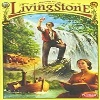

[[MatchNeighbor(id='1589946987', distance=682.5783081054688),
  MatchNeighbor(id='1589780604', distance=661.2794189453125),
  MatchNeighbor(id='B000CA2JQ6', distance=658.1710205078125),
  MatchNeighbor(id='B0000AX6EE', distance=655.8359375),
  MatchNeighbor(id='1932697810', distance=640.9542236328125)]]

In [190]:
CAT_ALLOWS = [] # ['Toys & Games']
CAT_DENIES = ['Baby'] # ['Arts, Crafts & Sewing']

TAG_ALLOWS = [] # ["even","odd"]
TAG_DENIES = [] # ["even","odd"]

QUERY_IMG_ID = cleaned_test_ids[:1][0]
QUERY_IMG_EMB = cleaned_test_embs[:1]


response = single_query_retrieval(
    index_endpoint_resource=my_ann_IndexEndpoint, 
    deployed_index_id='ann_1280_deployed_index_v5', 
    num_neighbs=5, 
    test_query=QUERY_IMG_EMB,
    query_id=QUERY_IMG_ID,
    cat_allows=CAT_ALLOWS, 
    cat_denies=CAT_DENIES, 
    tag_1_allows=TAG_ALLOWS,
    tag_1_denies=TAG_DENIES,
)

response

### restrict tag_1 namespace tokens

Restricts...
 cat_allows: [], cat_denies: ['Baby'],
tag_1_allows: ['even'], tag_1_denies: ['odd']

Elapsed time querying index-endpoint: 0.02 seconds

--> query item...

id: 098415096X | title: Malifaux: 2nd Edition Rulebook | description:
The next level of hurt is here. They've bringing back Malifaux with bigger guns, sharper teeth, and more chest-pounding action than you can believe. They've added new characters to the game and a new way to build each character using their brand new upgrade system. It doesn't stop there, new stories will keep you on your toes, while reliving past events from your favorite characters!



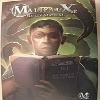


--> 5 nearest neighbors...

title: 'Warhammer Fantasy Roleplay: The Gathering Storm'
id: 1589946987 | dist: 682.58 | category: 'Toys & Games' | description:
'FFGWHF04 The Gathering Storm Warhammer Fantasy Roleplay Game by Fantasy Flight GamesDeath. Misery. Peril. Suffering. Disaster. And that is just the weather! The Gathering Storm is a complete campaign for Warhammer Fantasy Roleplay that centers around a series of bizarre events that bring the heroes face-to-face with dangerous enemies, moral dilemmas, and the raw fury of nature. In addition to introducing many sessions of exciting adventure, this campaign guide provides detailed information on the town of Stromdorf and a number of its odd citizens, as well as colorful maps that bring Stromdorf and the surrounding region to life.'


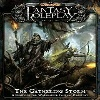



title: 'Once Upon a Time: Dark Tales'
id: 1589780604 | dist: 661.28 | category: 'Toys & Games' | description:
'Explore the grim side of your stories with the addition of the Dark Tales expansion to your Once Upon a Time storytelling card game. The 56 cards included in the set are designed to be mixed in with the original Once Upon a Time game, to provide new story elements and endings. In these stories, trolls lurk under every footbridge, inconsolable wraiths search for their lost loves, fiends tempt the innocent, and evil stepmothers serve up children in tasty stews.Not every fairy tale has a happy ending...'


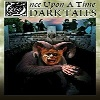



title: 'A Woman's View... Through Child Eyes'
id: B000CA2JQ6 | dist: 658.17 | category: 'Baby Products' | description:
'JACKIE RICHARDSON has been involved in Canada s blues, jazz and theatre scenes for more than 35 years.  A Woman s View...  features her diverse talent-extraordinary vocal prowess singing jazz, blues and gospel, along with sensitive readings of poems by Colina Philips and Salome Bey.'


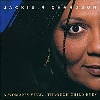



title: 'Lunch Money'
id: 1887801472 | dist: 631.37 | category: 'Toys & Games' | description:
'Lunch Money is an exciting, fast-paced, multi-player card game that combines dark, psychological images with the raw dynamics of a merciless street fight. This set is a complete game for two or more people. The two decks that come in the box are sufficient for at least four people. If you have more players, you may want to combine another set of cards, or simply be willing to reshuffle the discard pile when the draw pile runs out.'


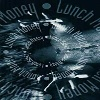



title: 'Huggies Overnites Diapers, Size 4, 31-Count (Pack of 2)'
id: B000FKETWU | dist: 628.51 | category: 'Baby Products' | description:
'A good nights rest starts with Huggies Overnites diapers. Sweet dreams for a baby who wakes up happy and dry.'


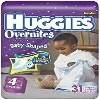

[[MatchNeighbor(id='1589946987', distance=682.5783081054688),
  MatchNeighbor(id='1589780604', distance=661.2794189453125),
  MatchNeighbor(id='B000CA2JQ6', distance=658.1710205078125),
  MatchNeighbor(id='1887801472', distance=631.3718872070312),
  MatchNeighbor(id='B000FKETWU', distance=628.5054931640625)]]

In [191]:
CAT_ALLOWS = [] # ['Toys & Games']
CAT_DENIES = ['Baby'] # ['Arts, Crafts & Sewing']

TAG_ALLOWS = ["even"] # ["even","odd"]
TAG_DENIES = ["odd"] # ["even","odd"]

QUERY_IMG_ID = cleaned_test_ids[:1][0]
QUERY_IMG_EMB = cleaned_test_embs[:1]


response = single_query_retrieval(
    index_endpoint_resource=my_ann_IndexEndpoint, 
    deployed_index_id='ann_1280_deployed_index_v5', 
    num_neighbs=5, 
    test_query=QUERY_IMG_EMB,
    query_id=QUERY_IMG_ID,
    cat_allows=CAT_ALLOWS, 
    cat_denies=CAT_DENIES, 
    tag_1_allows=TAG_ALLOWS,
    tag_1_denies=TAG_DENIES,
)

response

Restricts...
 cat_allows: [], cat_denies: ['Baby'],
tag_1_allows: ['odd'], tag_1_denies: ['even']

Elapsed time querying index-endpoint: 0.02 seconds

--> query item...

id: 098415096X | title: Malifaux: 2nd Edition Rulebook | description:
The next level of hurt is here. They've bringing back Malifaux with bigger guns, sharper teeth, and more chest-pounding action than you can believe. They've added new characters to the game and a new way to build each character using their brand new upgrade system. It doesn't stop there, new stories will keep you on your toes, while reliving past events from your favorite characters!



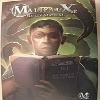


--> 5 nearest neighbors...

title: 'Chipper Jones Atlanta Braves All-Star 12x18 Lithograph'
id: B0000AX6EE | dist: 655.84 | category: 'Sports & Outdoors' | description:
'Get the Big Picture! A great collector's item for MLB fans. Large 12 x 18 lithograph.'


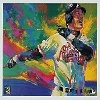



title: 'Living Stone'
id: 1932697810 | dist: 640.95 | category: 'Toys & Games' | description:
'Africa, 1855, The Scottish missionary, Dr. David Livingstone, has been researching African tribes and the flora and fauna of the area. As part of the Livingstone expedition, strategically set up tents in various regions, while collecting gemstones found along the Zambezi River bank. Gain the most victory points and the favor of Queen Victoria to win. 2 to 5 players. 35 minutes. In this game you follow in the footsteps of David Livingstone to the roaring Victoria Falls. On your way you may want to try your luck in the Diamond mining or you may prefer to seek a more calculable risk.'


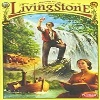



title: 'Minigame Library'
id: 1936920107 | dist: 635.12 | category: 'Toys & Games' | description:
'Why does a good game have to fill a gigantic box and weigh 10 pounds? The Level 99 Games Minigame Library is a collection of games small enough to fit in your pocket, but big enough to enjoy over and over again with friends and family. Each game fills a different niche, and each provides a different play experience. This means that no matter what group you're together with or what genre or style of game you're looking for, you'll be able to find pull out a game that provides 15-45 minutes of fun for a party of any size.Minigames are easy enough to teach in 5-10 minutes, but provide hours of repeated play and excitement. In a minigame, we look for a product that is simple to learn, deep to master, and extensively replayable and enjoyable. We guarantee that your fellow gamers will be requesting to play these games over and over again.Games include:

    NOIR - A deductive mystery thriller

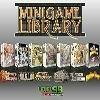



title: 'L'Oreal Paris Superior Preference Hair Color, 6A Light Ash Brown'
id: B00006JN4I | dist: 628.03 | category: 'Beauty' | description:
'Ultra Long-Lasting Coloring System. 20% More Fade-Resistant Color. Superior Fade-Resistant Colorant: 20% More color gel with Patented Fade-Resistant Colorants deeply replenishes every strand with rich, long-lasting color that shines. Brilliantly balanced shades stay true to the tone week after week - won't fade-out, turn dull or brassy. Patented Fade-Resistant Colorants for true color. Color-Saving Conditioning Creme: Care Supreme super-rich conditioning is more advanced than ever with a Color-Saving Complex. Enriched with Anti-Oxidant Vitamin E and UV Filters to help color defy fade-out and dry-out. Now, your color braves the elements - water, sun, wind. Hair stays silky and resilient. Up to 6 luxurious treatments to help keep first-day color vibrancy. Vitamin E and UV filters. Up to 6 weekly color-saving treatments. Luxurious Color Experience:

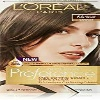



title: 'Cover Your Gray Lipstick For The Hair - Dark Brown'
id: B0000XMQSQ | dist: 622.17 | category: 'Beauty' | description:
'DKNY GOLDEN DELICIOUS by Donna Karan for WOMEN EAU DE PARFUM SPRAY 1.7 OZ (UNBOXED) Launched by the design house of Donna Karan in 2011, DKNY GOLDEN DELICIOUS by Donna Karan possesses a blend of juicy fruits with its fresh opening notes of apple and lily of the valley. It is recommended for casual wear.'


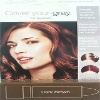

[[MatchNeighbor(id='B0000AX6EE', distance=655.8359375),
  MatchNeighbor(id='1932697810', distance=640.9542236328125),
  MatchNeighbor(id='1936920107', distance=635.1223754882812),
  MatchNeighbor(id='B00006JN4I', distance=628.032958984375),
  MatchNeighbor(id='B0000XMQSQ', distance=622.167724609375)]]

In [195]:
CAT_ALLOWS = [] # ['Toys & Games']
CAT_DENIES = ['Baby'] # ['Arts, Crafts & Sewing']

TAG_ALLOWS = ["odd"] # ["even","odd"]
TAG_DENIES = ["even"] # ["even","odd"]

QUERY_IMG_ID = cleaned_test_ids[:1][0]
QUERY_IMG_EMB = cleaned_test_embs[:1]


response = single_query_retrieval(
    index_endpoint_resource=my_ann_IndexEndpoint, 
    deployed_index_id='ann_1280_deployed_index_v5', 
    num_neighbs=5, 
    test_query=QUERY_IMG_EMB,
    query_id=QUERY_IMG_ID,
    cat_allows=CAT_ALLOWS, 
    cat_denies=CAT_DENIES, 
    tag_1_allows=TAG_ALLOWS,
    tag_1_denies=TAG_DENIES,
)

response

# Compute Recall

make the identical request to both indexes...

In [207]:
NUM_NEIGHBOURS=10

# ANN INDEX ENDPOINT
ann_matches = my_ann_IndexEndpoint.match(
    deployed_index_id='ann_1280_deployed_index_v5',
    queries=cleaned_test_embs, # [:1],
    num_neighbors=NUM_NEIGHBOURS,
)

# BRUTE FORCE INDEX ENDPOINT
exact_matches = my_bf_IndexEndpoint.match(
    deployed_index_id='brute_force_1280_deployed_index_v5',
    queries=cleaned_test_embs, # [:1],
    num_neighbors=NUM_NEIGHBOURS,
)

Calculate recall by determining how many neighbors were correctly retrieved as compared to the brute-force index

In [208]:
correct_neighbors = 0

for tree_ah_neighbors, brute_force_neighbors in zip(ann_matches, exact_matches):
    tree_ah_neighbor_ids = [neighbor.id for neighbor in tree_ah_neighbors]
    brute_force_neighbor_ids = [neighbor.id for neighbor in brute_force_neighbors]

    correct_neighbors += len(
        set(tree_ah_neighbor_ids).intersection(brute_force_neighbor_ids)
    )

recall = correct_neighbors / (len(cleaned_test_ids) * NUM_NEIGHBOURS)

print("Recall: {}".format(recall))

Recall: 1.0


In [211]:
# pprint(ann_matches)
# pprint(exact_matches)

pprint(f"Length of ann_matches: {len(ann_matches)}")
pprint(f"Length of exact_matches: {len(exact_matches)}")

pprint(f"correct_neighbors: {correct_neighbors}")

'Length of ann_matches: 10'
'Length of exact_matches: 10'
'correct_neighbors: 100'


In [210]:
correct_neighbors

100